Here I import the necessary packages

In [1]:
import numpy as np
import keras
import cv2
import pandas as pd
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import InputLayer
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import itertools
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


Here I initialise the file paths for the images and the labels

In [2]:
file_path = 'D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\celeba\img'
labels_path = 'D:\Admin\Documents\Year_4\AMLS\Assessment\dataset_AMLS_20-21\celeba\labels.csv'

Here I import the images and labels into a training data frame using pandas

In [3]:
dftr = pd.read_csv(labels_path)

dftr["smiling"] = dftr["smiling"].replace(to_replace=[-1], value=['Frown'])
dftr["smiling"] = dftr["smiling"].replace(to_replace=[1], value=['Smile'])
dftr["gender"] = dftr["gender"].replace(to_replace=[-1], value=['Female'])
dftr["gender"] = dftr["gender"].replace(to_replace=[1], value=['Male'])

one_hot_s = pd.get_dummies(dftr["smiling"])
one_hot_g = pd.get_dummies(dftr["gender"])
dftr = dftr.drop(columns=["gender", "smiling"])
dftr = dftr.join(one_hot_g)
dftr = dftr.join(one_hot_s)

Here I do the same thing but for a testing data frame

In [4]:
train, validation, test = \
              np.split(dftr.sample(frac=1), 
                       [int(.6*len(dftr)), int(.8*len(dftr))])

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(dataframe=train, 
                                              directory=file_path, 
                                              x_col="img_name", 
                                              y_col=["Frown", "Smile"], 
                                              class_mode="raw", 
                                              target_size=(55,45), 
                                              batch_size=30, 
                                              color_mode='grayscale', 
                                              interpolation='bicubic')

validation_generator = datagen.flow_from_dataframe(dataframe=validation, 
                                              directory=file_path, 
                                              x_col="img_name", 
                                              y_col=["Frown", "Smile"], 
                                              class_mode="raw", 
                                              target_size=(55,45), 
                                              batch_size=10, 
                                              color_mode='grayscale', 
                                              interpolation='bicubic')

test_generator = datagen.flow_from_dataframe(dataframe=test, 
                                              directory=file_path, 
                                              x_col="img_name", 
                                              y_col=["Frown", "Smile"], 
                                              class_mode="raw", 
                                              target_size=(55,45), 
                                              batch_size=10, 
                                              color_mode='grayscale', 
                                              interpolation='bicubic')

Found 3000 validated image filenames.
Found 1000 validated image filenames.
Found 1000 validated image filenames.


The above code generates batches of data to feed into the neural network architecture below

In [6]:
model = Sequential()
model.add(InputLayer(input_shape=(55,45,1)))
model.add(Conv2D(filters=100, kernel_size=(3,3), strides=2, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(filters=200, kernel_size=(2,2), strides=2, activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=2))
model.add(Conv2D(filters=400,kernel_size=(2,2),activation="relu"))
model.add(Flatten())
model.add(Dense(1024))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Dropout(0.2))
model.add(Dense(2, activation="softmax"))

The following code just compiles the neural network model

In [7]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
train_steps = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

The following code just trains the model

In [9]:
history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=train_steps,
                    validation_data=validation_generator,
                    validation_steps=validation_steps,
                    epochs=20)

Epoch 1/20
100/100 [==============================] - 10s 96ms/step - loss: 0.7550 - accuracy: 0.6460 - val_loss: 0.6782 - val_accuracy: 0.6080
Epoch 2/20
100/100 [==============================] - 9s 90ms/step - loss: 0.5081 - accuracy: 0.7657 - val_loss: 0.6864 - val_accuracy: 0.5280
Epoch 3/20
100/100 [==============================] - 9s 88ms/step - loss: 0.4051 - accuracy: 0.8153 - val_loss: 0.6695 - val_accuracy: 0.5430
Epoch 4/20
100/100 [==============================] - 9s 89ms/step - loss: 0.3140 - accuracy: 0.8570 - val_loss: 0.5568 - val_accuracy: 0.6020
Epoch 5/20
100/100 [==============================] - 9s 88ms/step - loss: 0.2456 - accuracy: 0.8910 - val_loss: 0.7233 - val_accuracy: 0.6970
Epoch 6/20
100/100 [==============================] - 9s 88ms/step - loss: 0.1764 - accuracy: 0.9297 - val_loss: 0.5097 - val_accuracy: 0.7860
Epoch 7/20
100/100 [==============================] - 9s 88ms/step - loss: 0.1221 - accuracy: 0.9510 - val_loss: 0.4147 - val_accuracy: 0.786

In [10]:
model.evaluate(test_generator)

100/100 [==============================] - 1s 15ms/step


[0.7320343255996704, 0.7900000214576721]

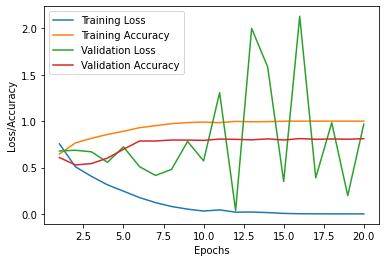

In [11]:
epochs = range(1, len(history.epoch) + 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()